In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    read_csv_from_web,
    implementPairDecayLimit,
    fromHB5Table1,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

mmu = 105.6583715e-3
mtau = 1.77682


# CMS 13TeV LHC

## `hSM > h h > mumu tautau`  [1805.04865](https://arxiv.org/abs/1805.04865)


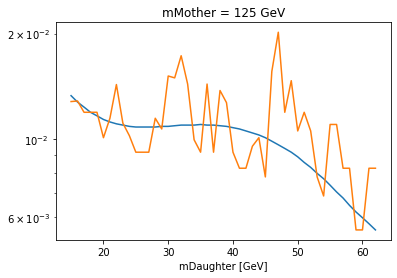

Looks good. Saving this to comb_LHC13_CMS_36.json


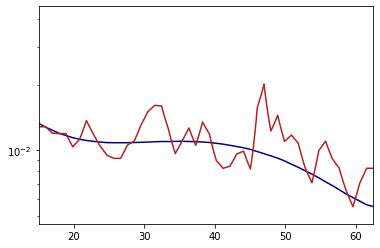

In [2]:
df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1673011/Table1/1/csv",
    comment="#",
    skiprows=118,
    skipfooter=327 - 167,
    engine="python",
    names=["mDaughter1", "exp"],
)

dfObs = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1673011/Table1/1/csv",
    comment="#",
    skiprows=277,
    names=["m", "obs"],
)
assert np.allclose(df.mDaughter1, dfObs.m)
df["obs"] = dfObs.obs
del dfObs
df["mMother"] = 125

prodModes = ["ggH", "vbfH"]  # b-jet veto
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC13", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn

limitFile = implementPairDecayLimit(
    "1805.04865",
    {
        "production": prodModes,
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "https://www.hepdata.net/record/ins1673011",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 40,
            "relative": 0,
        },  # bad due to neutrinos (p. 4)
    },
    constraints={
        "firstDaughter": [{"mumuTautauRatio": "odd"}],  # tautautautau also contributes
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(125)
hm = np.linspace(15, 62.5)
r = np.linspace(1e-4, 1e-3)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h2.setMass(mass)
    h2.setDecayWidth(
        "tautau",
        mtau ** 2
        / mmu ** 2
        * sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h2.br("mumu")
        * h2.totalWidth(),
    )
    HP.effectiveCouplingInput(
        hh, HP.scaledSMlikeEffCouplings(sqrt(rate / h2.br("mumu")))
    )
    hh.setDecayWidth("h2", "h1", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## `h125 > S S > mumu tautau`  [2005.08694](http://arxiv.org/abs/2005.08694)


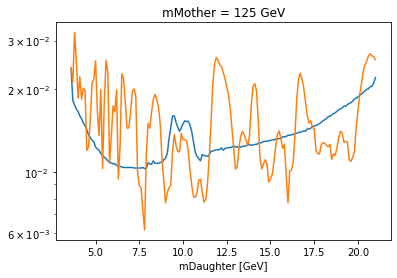

Looks good. Saving this to comb_light_125_LHC13_CMS_36.json


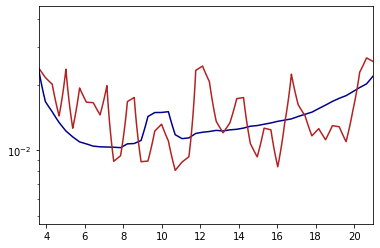

In [3]:
df = pd.read_csv("data/2005_08694_Fig7a.csv")
df["mMother"] = 125

prodModes = ["ggH", "vbfH"]
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC13", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn

limitFile = implementPairDecayLimit(
    "2005.08694",
    {
        "production": prodModes,
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "Fig. 7a",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,  # estimate from Fig 5
            "relative": 0,
        },
    },
    idSuffix=1,
    prefix="comb_light_125",
    constraints={
        "firstDaughter": [{"mumuTautauRatio": "odd"}],  # tautautautau also contributes
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(125)
hm = np.linspace(3.6, 21)
r = np.linspace(1e-4, 1e-3)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h2.setMass(mass)
    h2.setDecayWidth(
        "tautau",
        mtau ** 2
        / mmu ** 2
        * sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h2.br("mumu")
        * h2.totalWidth(),
    )
    HP.effectiveCouplingInput(
        hh, HP.scaledSMlikeEffCouplings(sqrt(rate / h2.br("mumu")))
    )
    hh.setDecayWidth("h2", "h1", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## `H(300) > S S > mumu tautau`  [2005.08694](http://arxiv.org/abs/2005.08694)

This limit offers only two mass slices, one at 125 and one at 300GeV. Since they look pretty different, we do not interpolate, but just use them separately on a mass window.

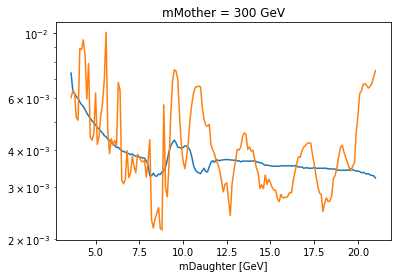

Looks good. Saving this to comb_light_300_LHC13_CMS_36.json


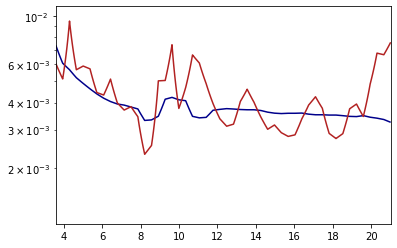

In [4]:
df = pd.read_csv("data/2005_08694_Fig7b.csv")
df["mMother"] = 300
prodModes = ["ggH", "vbfH"]
ref = HP.SMHiggs(300)
refCxn = np.sum([ref.cxn("LHC13", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn

limitFile = implementPairDecayLimit(
    "2005.08694",
    {
        "production": prodModes,
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "Fig. 7b",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 40,  # estimate from Fig 5
            "relative": 0,
        },
    },
    idSuffix=2,
    prefix="comb_light_300",
    constraints={
        "firstDaughter": [{"mumuTautauRatio": "odd"}],  # tautautautau also contributes
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(300)
hm = np.linspace(3.6, 21)
r = np.linspace(1e-4, 1e-3)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h2.setMass(mass)
    h2.setDecayWidth(
        "tautau",
        mtau ** 2
        / mmu ** 2
        * sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h2.br("mumu")
        * h2.totalWidth(),
    )
    HP.effectiveCouplingInput(
        hh, HP.scaledSMlikeEffCouplings(sqrt(rate / h2.br("mumu")))
    )
    hh.setDecayWidth("h2", "h1", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


# CMS 8TeV LHC

## `hSM > h h > mumu tautau`  [1701.02032](https://arxiv.org/abs/1701.02032)


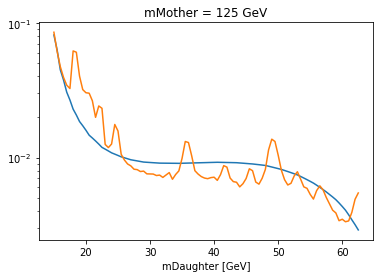

Looks good. Saving this to comb_LHC8_CMS_20.json


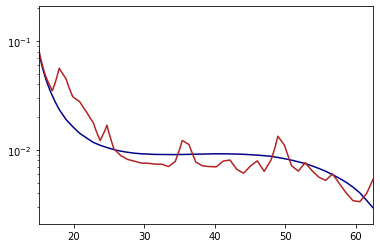

In [5]:
df = fromHB5Table1("170102032_CMS_HSM-aa-mumutautau_19.7fb-1", "CMS").rename(
    columns={"m": "mDaughter1"}
)
df["mMother"] = 125
prodModes = ["H", "vbfH", "HZ", "HW", "Htt"]
ref = HP.SMHiggs(125)
refCxn = np.sum([ref.cxn("LHC8", p) for p in prodModes])
df.obs *= refCxn
df.exp *= refCxn
limitFile = implementPairDecayLimit(
    "1701.02032",
    {
        "production": prodModes,
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "Fig. 6 (bottom-right)",
    df,
    idSuffix=3,  # other ids are different channels
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 50,
            "relative": 0,
        },  # given in sec 5.1
    },
    constraints={
        "mother": [
            {
                "modelLike": "SMHiggs",
                "process": {"channels": [[p, "none"] for p in prodModes]},
            }
        ],
        "firstDaughter": [{"mumuTautauRatio": "odd"}],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("tautau", 1.0)
h2.setDecayWidth("mumu", 1.0)
hh.setMass(125)
hm = np.linspace(15, 62.5)
r = np.linspace(1e-4, 1e-2)


def testAgainstLimit(mass, rate):
    from math import sqrt

    h1.setMass(mass)
    h2.setMass(mass)
    h2.setDecayWidth(
        "tautau",
        mtau ** 2
        / mmu ** 2
        * sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h2.br("mumu")
        * h2.totalWidth(),
    )
    HP.effectiveCouplingInput(
        hh, HP.scaledSMlikeEffCouplings(sqrt(rate / h2.br("mumu")))
    )
    hh.setDecayWidth("h1", "h2", 100)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r * refCxn, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r * refCxn, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
